# Downstream analysis after getting loom file from pySCENIC in linux

In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

In [2]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

# Load loom file (Direct result from linux pipeline)

In [3]:
f_pyscenic_output = "hswound_SCENIC_AUC.loom"

# Visualization of SCENIC's AUC matrix

In [4]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
lf.close()

In [14]:
auc_mtx

,ALX1(+),ALX3(+),AR(+),ARID3A(+),ASCL2(+),ATF1(+),ATF3(+),ATF4(+),ATF6(+),ATOH7(+),...,ZNF572(+),ZNF585B(+),ZNF658(+),ZNF718(+),ZNF770(+),ZNF831(+),ZNF84(+),ZNF91(+),ZNF93(+),ZSCAN32(+)
PWH26D0_AAACCCACACGTAACT-1,0.0,0.0,0.058398,0.019416,0.045190,0.000000,0.045398,0.063308,0.150970,0.000000,...,0.000000,0.0,0.00000,0.0,0.071300,0.000000,0.000000,0.052019,0.000000,0.0
PWH26D0_AAACCCACACTGAGGA-1,0.0,0.0,0.051158,0.003124,0.135355,0.000000,0.050433,0.062439,0.021464,0.018321,...,0.000000,0.0,0.00993,0.0,0.041542,0.007047,0.013153,0.049284,0.000000,0.0
PWH26D0_AAACCCAGTCCGACGT-1,0.0,0.0,0.077220,0.000000,0.050965,0.000000,0.052129,0.064804,0.057357,0.000000,...,0.000000,0.0,0.00000,0.0,0.035784,0.000000,0.000000,0.039423,0.000000,0.0
PWH26D0_AAACCCATCAGCGGAA-1,0.0,0.0,0.077714,0.022184,0.168175,0.000000,0.056860,0.065688,0.056271,0.000000,...,0.000000,0.0,0.00000,0.0,0.066357,0.000000,0.039777,0.048886,0.000000,0.0
PWH26D0_AAACGAACAATGAAAC-1,0.0,0.0,0.071070,0.013943,0.062128,0.000000,0.049599,0.068665,0.118490,0.000000,...,0.000000,0.0,0.00000,0.0,0.049841,0.001535,0.000317,0.044769,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWH28D7_TTTGGAGGTGCCTAAT-1,0.0,0.0,0.003396,0.000000,0.068399,0.000000,0.040923,0.053780,0.021671,0.000000,...,0.000000,0.0,0.00000,0.0,0.008158,0.000000,0.000000,0.009213,0.000000,0.0
PWH28D7_TTTGGAGTCGAGTCCG-1,0.0,0.0,0.007443,0.002537,0.082083,0.000000,0.042368,0.053955,0.055081,0.000000,...,0.020623,0.0,0.00000,0.0,0.015321,0.001552,0.005748,0.016533,0.000000,0.0
PWH28D7_TTTGTTGAGGTCCTGC-1,0.0,0.0,0.079086,0.020338,0.248017,0.038305,0.058176,0.062778,0.150711,0.055320,...,0.000000,0.0,0.00000,0.0,0.036262,0.000145,0.042246,0.059916,0.107215,0.0
PWH28D7_TTTGTTGAGTAGACCG-1,0.0,0.0,0.083449,0.013147,0.129730,0.000000,0.061383,0.060217,0.017585,0.000000,...,0.000000,0.0,0.00000,0.0,0.051032,0.000000,0.028070,0.052173,0.000000,0.0


# Integrate the output

In [5]:
# scenic output
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv('scenic_binary_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv('scenic_binary_tsne.txt', sep='\t', header=0, index_col=0 )
###

## Fix regulon objects to display properly in SCope

In [6]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/Users/zhuliu/miniconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


## Concatenate embeddings (tSNE, UMAP, etc.)

In [7]:
adata=sc.read("allNew_scanpy_subkeratins.h5ad")
adata

AnnData object with n_obs × n_vars = 27105 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'MainCellTypes', 'SubCellTypes', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.0.5', 'SCT_snn_res.1', 'CellTypes', 'mig_score1', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2'
    uns: 'CellTypes_colors', 'Condition_colors', 'seurat_clusters_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [11]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = np.quantile(nGenesDetectedPerCell, [.01, .05, .10, .50, 1])
print(percentiles)

percentiles_index = np.array([.01, .05, .10, .50, 1])

[1342.36 2496.2  2856.   4194.   9823.  ]


/Users/zhuliu/miniconda3/envs/newpyscenic/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


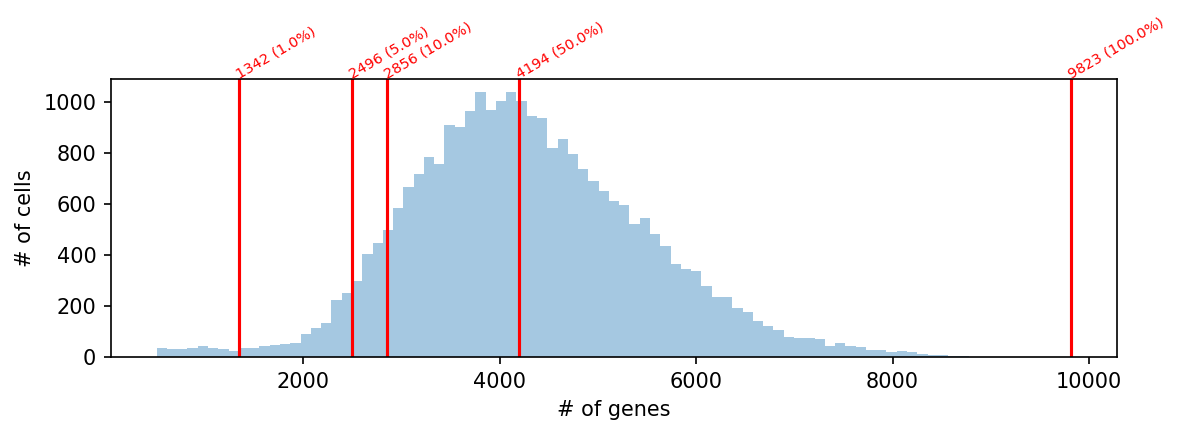

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles_index[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [8]:
#Change the data type of the column if it is wrong
adata.obs[["CellTypes"]] = adata.obs[["CellTypes"]].astype("category")
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,Patient,Gender,Age,Condition,Doublet,percent.mt,percent.ribo,...,SubCellTypes,SCT_snn_res.0.8,seurat_clusters,SCT_snn_res.0.5,SCT_snn_res.1,CellTypes,mig_score1,monocle3_pseudotime,UMAP_1,UMAP_2
barcode,,,,,,,,,,,,,,,,,,,,,
PWH26D0_AAACCCACACGTAACT-1,PWH26D0,27681,5164,PWH26,Male,29,Skin,Singlet,5.447562,32.745491,...,Spi_I_cl1,3,6,0,6,Spi_II,-0.420636,35.835173,4.514600,4.859426
PWH26D0_AAACCCACACTGAGGA-1,PWH26D0,17228,3981,PWH26,Male,29,Skin,Singlet,7.936756,37.161284,...,Spi_II_cl4,3,6,3,6,Spi_I,-0.442993,25.157929,1.166001,3.640951
PWH26D0_AAACCCAGTCCGACGT-1,PWH26D0,19962,3928,PWH26,Male,29,Skin,Singlet,6.533741,42.505817,...,Spi_I_cl1,3,0,0,0,Spi_II,-0.427993,28.658110,2.272555,2.760318
PWH26D0_AAACCCATCAGCGGAA-1,PWH26D0,19153,4177,PWH26,Male,29,Skin,Singlet,5.637100,36.548496,...,Spi_II_cl4,4,3,3,3,Spi_I,-0.218841,20.894251,-1.438334,2.228174
PWH26D0_AAACGAACAATGAAAC-1,PWH26D0,26084,4679,PWH26,Male,29,Skin,Singlet,5.279887,40.893519,...,Spi_I_cl1,3,6,0,6,Spi_II,-0.440837,25.781815,1.770500,3.679583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWH28D7_TTTGGAGGTGCCTAAT-1,PWH28D7,66880,6790,PWH28,Male,24,Wound7,Singlet,3.398883,29.004952,...,Bas_II_cl6,5,7,5,7,Bas_II,0.610174,11.273101,-3.661146,0.786490
PWH28D7_TTTGGAGTCGAGTCCG-1,PWH28D7,16428,2948,PWH28,Male,24,Wound7,Singlet,5.780579,46.834718,...,Spi_I_cl1,3,0,0,0,Spi_II,-0.122513,24.044449,1.691677,2.211341
PWH28D7_TTTGTTGAGGTCCTGC-1,PWH28D7,6449,2316,PWH28,Male,24,Wound7,Singlet,8.081644,32.492070,...,Bas_I_cl3,0,2,1,2,Bas_I,-0.249604,4.049451,-7.507584,-3.604315


In [ ]:
sc.pl.umap(adata, color=['CellTypes', 'Condition'])

In [14]:
umapDF = pd.DataFrame(adata.obsm['X_umap'], columns=['_X', '_Y'])

In [15]:
Embeddings_X = pd.DataFrame(index=lf.ca.CellID)
Embeddings_X = pd.concat([
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0],
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0],
        dr_tsne['X'] ,
        dr_umap['X']
        ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame(index=lf.ca.CellID)
Embeddings_Y = pd.concat([
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1],
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1],
        dr_tsne['Y'] ,
        dr_umap['Y']
        ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [16]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": 1,
        "name": "Seurat umap"
    },
    {
        "id": 2,
        "name": "Seurat PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Seurat",
            "name": "Seurat louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }, {
            "name": "S_score"
        }, {
            "name": "G2M_score"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Seurat",
        "values": list(set(adata.obs['SCT_snn_res.0.5'].astype(np.str)))
    },
    {
        "name": "Sample",
        "values": list(set(adata.obs['orig.ident'].values))
    },
    {
        "name": "Condition",
        "values": list(set(adata.obs['Condition'].values))
    },
    {
        "name": "CellCycle",
        "values": list(set(adata.obs['Phase'].values))
    },
    {
        "name": "CellTypes",
        "values": list(set(adata.obs['CellTypes'].values))
    }
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['SCT_snn_res.0.5']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['SCT_snn_res.0.5'].values.astype(np.int64)

/var/folders/5g/39bmwc9139g5cvtdl4c0pxtwnwd5fl/T/ipykernel_13635/4049543245.py:47: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "values": list(set(adata.obs['SCT_snn_res.0.5'].astype(np.str)))


## Assemble loom file row and column attributes

In [17]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [18]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['nCount_RNA'].values),
    "nGene": np.array(adata.obs['nFeature_RNA'].values),
    "Percent_mito": np.array(adata.obs['percent.mt'].values),
    "S_score": np.array(adata.obs['S.Score'].values),
    "G2M_score": np.array(adata.obs['G2M.Score'].values),
    "Louvain_clusters_Seurat": np.array(adata.obs['SCT_snn_res.0.5'].values),
    "Sample": np.array(adata.obs['orig.ident'].values),
    "Condition": np.array(adata.obs['Condition'].values),
    "CellCycle": np.array(adata.obs['Phase'].values),
    "CellTypes": np.array(adata.obs['CellTypes'].values),
    "Embedding": dfToNamedMatrix(umapDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['SCT_snn_res.0.5'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "hsWound",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [19]:
lp.create(
    filename = "hswound_SCENIC_AUC_final_binaryUMAP.loom",
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

# Visualization of SCENIC results

In [9]:
# import dependencies
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose


from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores


In [10]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'hswound_SCENIC_AUC_final_binaryUMAP.loom'

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

# Extract relevant data from the integrated loom file

In [22]:
# scenic output
lf = lp.connect(f_final_loom, mode='r', validate=False)
meta = json.loads(zlib.decompress(base64.b64decode(lf.attrs.MetaData)))
exprMat = pd.DataFrame(lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
auc_mtx_cp = auc_mtx.copy() #make a copy for cellAnnot
auc_mtx_cp = auc_mtx_cp.add_prefix('Regulon_') #add same pattern name to column names

In [23]:
#extract annotations
CellTypes = pd.DataFrame(lf.ca.CellTypes, index=lf.ca.CellID, columns=['CellTypes'])
ClusterID = pd.DataFrame(lf.ca.ClusterID, index=lf.ca.CellID, columns=['ClusterID'])
Sample = pd.DataFrame(lf.ca.Sample, index=lf.ca.CellID, columns=['Sample'])
Condition = pd.DataFrame(lf.ca.Condition, index=lf.ca.CellID, columns=['Condition'])
CellCycle = pd.DataFrame(lf.ca.CellCycle, index=lf.ca.CellID, columns=['CellCycle'])
Louvain_clusters_Seurat = pd.DataFrame(lf.ca.Louvain_clusters_Seurat, index=lf.ca.CellID, columns=['Louvain_clusters_Seurat'])
Percent_mito = pd.DataFrame(lf.ca.Percent_mito, index=lf.ca.CellID, columns=['Percent_mito'])
S_score = pd.DataFrame(lf.ca.S_score, index=lf.ca.CellID, columns=['S_score'])
G2M_score = pd.DataFrame(lf.ca.G2M_score, index=lf.ca.CellID, columns=['G2M_score'])
nGene = pd.DataFrame(lf.ca.nGene, index=lf.ca.CellID, columns=['nGene'])
nUMI = pd.DataFrame(lf.ca.nUMI, index=lf.ca.CellID, columns=['nUMI'])

In [24]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [25]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        CellTypes,
        ClusterID,
        Sample,
        Condition,
        CellCycle,
        Louvain_clusters_Seurat,
        Percent_mito,
        S_score,
        G2M_score,
        nGene,
        nUMI,
        auc_mtx_cp
    ],
    axis=1
)

In [ ]:
cellAnnot.to_csv('z_hswoundWound_cellType_metadata_addRegulons.csv') 
cellAnnot

In [26]:
auc_mtx.to_csv('z_hswoundWound_Regulons_auc_mtx.csv') 

In [26]:
# capture embeddings:
dr = [
    pd.DataFrame(lf.ca.Embedding, index=lf.ca.CellID)
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame(lf.ca.Embeddings_X, index=lf.ca.CellID)
dry = pd.DataFrame(lf.ca.Embeddings_Y, index=lf.ca.CellID)

for i in range(len(drx.columns)-1):
    dr.append( pd.concat([drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer'))
    dr_names.append(meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-'))

# rename columns:
for i,x in enumerate(dr):
    x.columns = ['X','Y']
    
#remember to close the loom file
lf.close()

# Display a motifs table with motif logos

In [11]:
#View the motifs table along with motif logos
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/" 
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 5, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [ ]:
df_motifs = load_motifs("hswound_reg.csv")
selected_motifs = ['E2F1', 'ILf2']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

#display_logos(df_motifs.head())
display_logos(df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(5))

In [13]:
sc.tl.tsne(adata, n_pcs=30, use_rep='X_harmony', perplexity=50, n_jobs=10)

computing tSNE
    using sklearn.manifold.TSNE


/Users/zhuliu/miniconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_tsne.py:115: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  "In previous versions of scanpy, calling tsne with n_jobs > 1 would use "


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:11)


In [ ]:
sc.set_figure_params(dpi=400, fontsize=8)
sc.pl.tsne(adata, color=['CellTypes', 'Condition'])

In [107]:
adata

AnnData object with n_obs × n_vars = 27105 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'MainCellTypes', 'SubCellTypes', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.0.5', 'SCT_snn_res.1', 'CellTypes', 'mig_score1', 'monocle3_pseudotime', 'UMAP_1', 'UMAP_2'
    uns: 'CellTypes_colors', 'Condition_colors', 'seurat_clusters_colors', 'tsne'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'X_tsne'

In [83]:
embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [111]:
# We add all metadata derived from SCENIC to the scanpy.AnnData object.
add_scenic_metadata(adata, auc_mtx)
adata.write_h5ad('allNew_scanpy_subkeratins_addAUC.h5ad')

In [16]:
adata=sc.read('allNew_scanpy_subkeratins_addAUC.h5ad')

In [17]:
#sc.tl.tsne(adata, use_rep='X_aucell', perplexity=50, n_jobs=10)

In [ ]:
sc.pl.tsne(adata, color=['CellTypes', 'Condition'], title=['Cell types based on regulons', 'Conditions based on regulons'])

In [ ]:
for batch in ['Skin', 'Wound1', 'Wound7', 'Wound30']:
    adata.sub=adata[adata.obs['Condition'].isin([batch])]
    sc.pl.tsne(adata.sub, color=['CellTypes'], title=['Cell types based on regulons'], frameon=None)

In [72]:
embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [ ]:
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['CellTypes']]
df_results = ((df_scores.groupby(by='CellTypes').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 3.0)].sort_values('Z', ascending=False).head()

In [175]:
cellType_top3reg = df_results.sort_values('Z', ascending=False).groupby(by='CellTypes').head(5).sort_values('CellTypes', ascending=False)
print(len(cellType_top3reg['regulon'].unique()))
print(len(cellType_top3reg['CellTypes'].unique()))

43
9


In [ ]:
cellType_top3reg

In [177]:
df_heatmap = pd.pivot_table(data=cellType_top3reg,
                           index='CellTypes', columns='regulon', values='Z')

In [ ]:
df_heatmap

In [ ]:
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')

In [ ]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 2.0].sort_values('Z', ascending=False),
                           index='CellTypes', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')
#savesvg('heatmap_regulons.svg', fig)

In [ ]:
rss = regulon_specificity_scores(auc_mtx, adata.obs.CellTypes)
rss.head()

In [ ]:
from adjustText import adjust_text
cats=['Bas_I',
      'Bas_II',
      'Bas_III',
      'Spi_I',
      'Spi_II',
      'Spi_III',
      'Spi_IV',
      'Spi_V',
      'Gra_I']
fig = plt.figure(figsize=(12,12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(3,3,num)
    plot_rss(rss, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
#plt.savefig("z_hsWound_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [ ]:
sc.set_figure_params(dpi=400, fontsize=8)
sc.pl.tsne(adata, color=['CellTypes', 'Regulon(SIRT6(+))','Regulon(ZNF831(+))',
                         'Regulon(BANP(+))','Regulon(MTA3(+))','Regulon(RELA(+))', 
                         'Regulon(XBP1(+))','Regulon(NFATC1(+))','Regulon(STAT3(+))',
                         'Regulon(FOSL1(+))','Regulon(E2F4(+))'],
           cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["red"]], as_cmap=True),
           ncols=4, save="rss_spiv.pdf")

In [ ]:
sc.set_figure_params(dpi=400, fontsize=8)
sc.pl.tsne(adata, color=['CellTypes', 'Regulon(GIT2(+))','Regulon(NKX2-8(+))',
                         'Regulon(EOMES(+))','Regulon(MSC(+))','Regulon(SOX8(+))', 
                         'Regulon(SMARCB1(+))','Regulon(ELF4(+))','Regulon(SNAI2(+))',
                         'Regulon(ASCL2(+))','Regulon(PML(+))'],
           cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["red"]], as_cmap=True),
           ncols=4, save="rss_bas3.pdf")

In [ ]:
df_results.sort_values('Z', ascending=False).groupby(by='CellTypes').head(5).sort_values('regulon')

In [ ]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = df_obs
#names = list(map(op.attrgetter('Regulon'), filter(lambda r: r.score > 8.0, regulons)))
sc.pl.stacked_violin(aucell_adata, 'Regulon(ALX1(+))', groupby='CellTypes')

# Dimensionality reduction plots

In [27]:
def colorMap(x, palette='bright'):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict(zip( list(set(x)), cpalette))
    cmap = [cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [ ]:
plt.rcParams.update({'font.size':8})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,12), dpi=300 )

drplot(dr[0], colorlab=cellAnnot['CellTypes'], ax=ax1, palette='bright', s=2, title='Seurat - UMAP' )

drplot(dr[3], colorlab=cellAnnot['CellTypes'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="")

#plt.tight_layout()
#plt.savefig("hswoundWound-umap-seurat-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

# Regulon specificity scores (RSS) across predicted cell types

In [32]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

## Calculate RSS

In [33]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['CellTypes'] )
rss_cellType

,ALX1_(+),ALX3_(+),AR_(+),ARID3A_(+),ASCL2_(+),ATF1_(+),ATF3_(+),ATF4_(+),ATF6_(+),ATOH7_(+),...,ZNF572_(+),ZNF585B_(+),ZNF658_(+),ZNF718_(+),ZNF770_(+),ZNF831_(+),ZNF84_(+),ZNF91_(+),ZNF93_(+),ZSCAN32_(+)
Spi_II,0.178285,0.194468,0.386199,0.336191,0.298966,0.194055,0.383241,0.370513,0.367384,0.261966,...,0.229908,0.227327,0.232902,0.189479,0.388042,0.237420,0.303472,0.382536,0.176149,0.194156
Spi_I,0.176516,0.186907,0.304607,0.250296,0.280920,0.192529,0.294839,0.294800,0.276218,0.243174,...,0.219618,0.211086,0.212977,0.181585,0.286759,0.223902,0.263125,0.296121,0.180387,0.190407
Bas_I,0.194195,0.184321,0.369986,0.327213,0.504046,0.446768,0.358770,0.359243,0.347472,0.329024,...,0.212629,0.287674,0.199604,0.207419,0.312066,0.247099,0.374531,0.373608,0.213318,0.224681
Spi_III,0.171896,0.179735,0.262950,0.332305,0.221432,0.172430,0.294476,0.288519,0.308693,0.193025,...,0.185774,0.202287,0.188715,0.178028,0.320089,0.246034,0.222449,0.283769,0.168816,0.174247
Gra_I,0.178948,0.172215,0.187592,0.201877,0.177110,0.168836,0.204837,0.205304,0.233434,0.169269,...,0.171115,0.209949,0.169912,0.168760,0.240220,0.294048,0.200031,0.210241,0.169349,0.169582
Spi_V,0.173612,0.178615,0.267054,0.287304,0.253097,0.181962,0.308912,0.325093,0.273094,0.228050,...,0.185184,0.189921,0.184597,0.175915,0.308892,0.387454,0.206925,0.281134,0.171344,0.179104
Spi_IV,0.171695,0.170769,0.185903,0.191038,0.179620,0.171575,0.190676,0.187851,0.185263,0.176592,...,0.171839,0.183593,0.170890,0.172873,0.188472,0.189038,0.179347,0.186559,0.169312,0.172637
Bas_II,0.172690,0.175823,0.254096,0.213104,0.259027,0.210966,0.243284,0.248642,0.221941,0.227070,...,0.182499,0.186294,0.178512,0.204210,0.224834,0.192186,0.244536,0.243981,0.171162,0.181747
Bas_III,0.171738,0.168828,0.197256,0.188412,0.256875,0.231443,0.207874,0.218687,0.193738,0.218490,...,0.172481,0.179011,0.168729,0.172207,0.196377,0.194472,0.190203,0.203678,0.174759,0.173109


In [34]:
#export the results to files for next time use
rss_cellType.to_csv('z_hswoundWound_cellType_RSSs.csv') 

## RSS panel plot with all cell types 

In [ ]:
cats = sorted(list(set(cellAnnot['CellTypes'])))

fig = plt.figure(figsize=(12,12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(3,3,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("z_hsWound_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

## Select the top 5 regulons from each cell type

In [40]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [41]:
print(len(topreg))
print(*topreg) #display all the top rss TFs

43
EN1_(+) YEATS4_(+) MYBL1_(+) SNAI2_(+) MYB_(+) E2F7_(+) E2F1_(+) NKX2-8_(+) DLX3_(+) EN2_(+) GIT2_(+) SMARCC2_(+) NR2F1_(+) LHX6_(+) AR_(+) ZNF326_(+) MSC_(+) STAT4_(+) ELF4_(+) RELA_(+) THAP1_(+) SIRT6_(+) STAT5A_(+) ZNF831_(+) KLF8_(+) SMAD3_(+) USF2_(+) SOX8_(+) MTA3_(+) DBX2_(+) FOXI3_(+) PRDM1_(+) RARG_(+) EOMES_(+) BANP_(+) NFE2L1_(+) PBX1_(+) IRF5_(+) NR1I3_(+) ID4_(+) MAF_(+) NEUROD2_(+) GADD45A_(+)


## Generate a Z-score for each regulon to enable comparison between regulons

In [ ]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )


In [ ]:
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [ ]:
auc_mtx_Z

## Generate a heatmap 

In [44]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [45]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['CellTypes'] ]

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

In [ ]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("z_hsWound_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

## Generate a binary regulon activity matrix: 

In [49]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=6 )
binary_mtx.head()

,ALX1_(+),ALX3_(+),AR_(+),ARID3A_(+),ASCL2_(+),ATF1_(+),ATF3_(+),ATF4_(+),ATF6_(+),ATOH7_(+),...,ZNF572_(+),ZNF585B_(+),ZNF658_(+),ZNF718_(+),ZNF770_(+),ZNF831_(+),ZNF84_(+),ZNF91_(+),ZNF93_(+),ZSCAN32_(+)
PWH26D0_AAACCCACACGTAACT-1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
PWH26D0_AAACCCACACTGAGGA-1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
PWH26D0_AAACCCAGTCCGACGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PWH26D0_AAACCCATCAGCGGAA-1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
PWH26D0_AAACGAACAATGAAAC-1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#export the results to files for next time use
binary_mtx.to_csv('z_hsWound_cellType_binarize.csv') 
auc_thresholds.to_frame().rename(columns={0:'threshold'}).to_csv('z_hsWound_cellType_binarize_thresholds.csv')

In [51]:
#read the file
binary_mtx = pd.read_csv('z_hsWound_cellType_binarize.csv', index_col=0)
auc_thresholds = pd.read_csv('z_hsWound_cellType_binarize_thresholds.csv', index_col=0).threshold

In [52]:
import umap

# UMAP using binary regulon activity
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap(binary_mtx)
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=binary_mtx.index).to_csv("scenic_binary_umap.txt", sep='\t')
# tSNE
tsne = TSNE(n_jobs=10)
dr_tsne = tsne.fit_transform(binary_mtx)
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=binary_mtx.index).to_csv("scenic_binary_tsne.txt", sep='\t')


In [ ]:
# select regulons:
r = [ 'E2f7_(+)', 'Nfe2_(+)', 'Dlx5_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('miceWound_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

## Plot the selected regulons you are interested in

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

plot_binarization(auc_mtx, 'Tfap4_(+)', auc_thresholds['Tfap4_(+)'], ax=ax1)
plot_binarization(auc_mtx, 'Meis2_(+)', auc_thresholds['Meis2_(+)'], ax=ax2)
plot_binarization(auc_mtx, 'Tcf23_(+)', auc_thresholds['Tcf23_(+)'], ax=ax3)
plot_binarization(auc_mtx, 'Faap24_(+)', auc_thresholds['Faap24_(+)'], ax=ax4)
plot_binarization(auc_mtx, 'Arnt2_(+)', auc_thresholds['Arnt2_(+)'], ax=ax5)
plot_binarization(auc_mtx, 'Nfatc3_(+)', auc_thresholds['Nfatc3_(+)'], ax=ax6)
plot_binarization(auc_mtx, 'Nfe2_(+)', auc_thresholds['Nfe2_(+)'], ax=ax7)
plot_binarization(auc_mtx, 'Dlx5_(+)', auc_thresholds['Dlx5_(+)'], ax=ax8)

plt.tight_layout()
#savesvg('hists - GSE115978 - binarization.svg', fig)

## Create heatmap with binarized regulon activity

In [59]:
#Same function as above heatmap based on RSS 
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [68]:
cats = sorted(list(set(cellAnnot['CellTypes'])))
colors = sns.color_palette('bright',n_colors=len(cats))
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['CellTypes'] ]

In [ ]:
cell_type_color_lut = dict(zip(cellAnnot['CellTypes'], colors))
bw_palette = sns.xkcd_palette(["white", "black"])
sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

In [ ]:
sns.set()
sns.set(font_scale=1.2)
g = sns.clustermap(binary_mtx[topreg], annot=False, square=False, linecolor='gray',
                   row_colors=colormap, yticklabels=False, xticklabels=True, 
                   cmap=bw_palette, figsize=(21,16))
g.cax.set_visible(False)
#g.ax_row_dendrogram.set_visible(False)
#g.ax_col_dendrogram.set_visible(False)
#g.ax_heatmap.set_xlabel('Regulons')
#g.ax_heatmap.set_ylabel('Cells')
plt.savefig("miceWound_cellType-heatmap-binary-top5.pdf", dpi=600, bbox_inches = "tight")

### CELL TYPE SPECIFIC REGULATORS - Z-SCORE 

In [ ]:
#This is different from above Z-score (Here focus on each cell type)
signature_column_names = list(cellAnnot.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon_'), signature_column_names))
df_scores = cellAnnot[signature_column_names + ['CellTypes']]

df_results = ((df_scores.groupby(by='CellTypes').mean() - cellAnnot[signature_column_names].mean())/ cellAnnot[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:], df_results.regulon))
df_results[(df_results.Z >= 3.0)].sort_values('Z', ascending=False).head(10)

In [54]:
df_results.to_csv('z_hsWound_cellType_Z-scores.csv') 

In [63]:
cellType_top3reg = df_results.sort_values('Z', ascending=False).groupby(by='CellTypes').head(10).sort_values('CellTypes', ascending=False)
print(len(cellType_top3reg['regulon'].unique()))
print(len(cellType_top3reg['CellTypes'].unique()))

85
9


In [ ]:
cellType_top3reg

In [ ]:
plt.rcParams.update({'font.size':12})
df_heatmap = pd.pivot_table(data=cellType_top3reg,
                           index='regulon', columns='CellTypes', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) #leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(30, 20), dpi=150)
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 10})
ax1.set_ylabel('')
plt.tight_layout()
plt.savefig('z_hsWound_cellType-heatmap-Z-scores.pdf', dpi=600, bbox_inches = "tight")

#### Try to unstand the index and columns of df in order to control the x and y labels in heatmap 

In [58]:
binary_mtx.T.index

Index(['ALX1_(+)', 'ALX3_(+)', 'AR_(+)', 'ARID3A_(+)', 'ASCL2_(+)', 'ATF1_(+)',
       'ATF3_(+)', 'ATF4_(+)', 'ATF6_(+)', 'ATOH7_(+)',
       ...
       'ZNF572_(+)', 'ZNF585B_(+)', 'ZNF658_(+)', 'ZNF718_(+)', 'ZNF770_(+)',
       'ZNF831_(+)', 'ZNF84_(+)', 'ZNF91_(+)', 'ZNF93_(+)', 'ZSCAN32_(+)'],
      dtype='object', length=384)

In [ ]:
binary_mtx.index

In [33]:
import operator as op

In [30]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [31]:
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [ ]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T